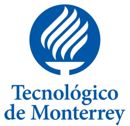

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegación autónoma**
### Tecnológico de Monterrey
###  	Dr. David Antonio Torres

#### **Actividad 4.2 - Detección de Señales de Tránsito**
____


**Nombres y matrículas de los integrantes del equipo:**

*   Julio Cesar Lynn Jimenez A01793660
*   Francisco Javier Parga García A01794380
*   Carlos Roberto Torres Ferguson A01215432
*   Fernando Sebastian Sanchez Cardona A01687530

____

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (5,3)

In [2]:
train_directory = 'data/Train'
test_directory = 'data/Test'

In [3]:
# Create generator with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest',
                                   validation_split=0.25)

In [4]:
batch_size = 128
image_size = (28,28)
# Keras ImageDataGenerator provides a method flow_from_directory to load images in batches
# This is useful for large datasets to fit into memory
train_generator = train_datagen.flow_from_directory(train_directory,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    classes= list(map(str,range(0,43))),
                                                    subset='training')  # set as training data

validation_generator = train_datagen.flow_from_directory(train_directory,  # same directory as training data
                                                         target_size=image_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         classes=  list(map(str,range(0,43))),
                                                         subset='validation')  # set as validation data

Found 29416 images belonging to 43 classes.
Found 9793 images belonging to 43 classes.


In [5]:
def initialize_model():
    model = Sequential()

    ### First Convolution & MaxPooling
    model.add(Conv2D(32, (3,3),padding = "same", input_shape=image_size+(3,), activation="relu"))
    model.add(Conv2D(32, (3,3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    ### Third Conv
    model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))

    ### Flattening
    model.add(Flatten())
    
    ### One "Dense" layer
    model.add(Dense(392, activation='relu'))
    model.add(Dropout(0.5))
    

    ### Last layer 43 outputs
    model.add(Dense(43, activation='softmax')) #Softmax(43)  
    return model


def compile_model(model):

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', 'Recall', 'Precision']) 
    return model

In [6]:
model_keras = initialize_model()
model_keras = compile_model(model_keras)

model_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                        

In [7]:
early_stop = EarlyStopping(monitor = 'val_accuracy', 
                           mode = 'max', 
                           patience = 7,  
                           restore_best_weights = True,
                           verbose=1)

model_checkpoint = ModelCheckpoint('best_model.h5', 
                                   monitor='val_accuracy', 
                                   mode='max', 
                                   verbose=1, 
                                   save_best_only=True)

In [8]:
%%time

history = model_keras.fit(train_generator,
                            epochs=101,
                            validation_data=validation_generator,
                            callbacks=[early_stop, model_checkpoint]) 

Epoch 1/101
229/230 [============================>.] - ETA: 0s - loss: 2.2237 - accuracy: 0.3723 - recall: 0.2011 - precision: 0.7761
Epoch 1: val_accuracy improved from -inf to 0.65006, saving model to best_model.h5
230/230 [==============================] - 17s 60ms/step - loss: 2.2190 - accuracy: 0.3734 - recall: 0.2024 - precision: 0.7761 - val_loss: 1.1673 - val_accuracy: 0.6501 - val_recall: 0.4419 - val_precision: 0.8339
Epoch 2/101
230/230 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.7392 - recall: 0.6337 - precision: 0.8521
Epoch 2: val_accuracy improved from 0.65006 to 0.78679, saving model to best_model.h5
230/230 [==============================] - 13s 57ms/step - loss: 0.7952 - accuracy: 0.7392 - recall: 0.6337 - precision: 0.8521 - val_loss: 0.6740 - val_accuracy: 0.7868 - val_recall: 0.7178 - val_precision: 0.8693
Epoch 3/101
229/230 [============================>.] - ETA: 0s - loss: 0.4520 - accuracy: 0.8499 - recall: 0.8032 - precision: 0.8981

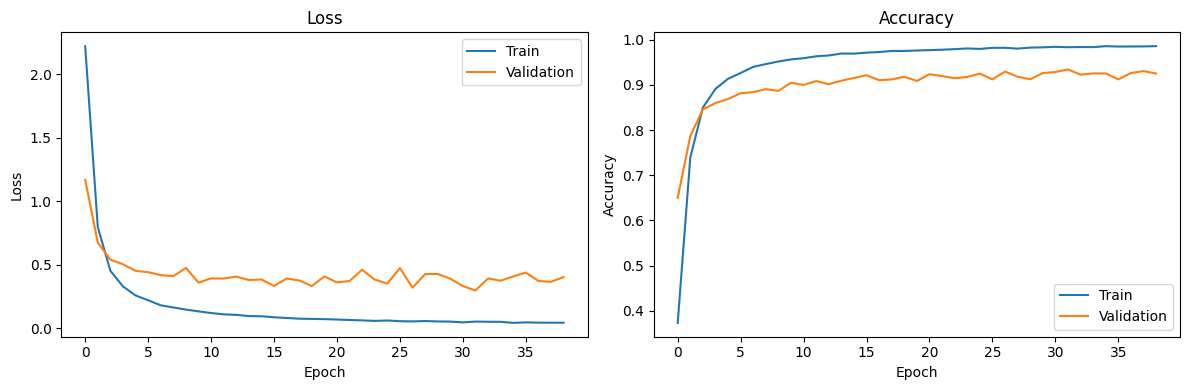

In [9]:
# Plot the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [6]:
# Load the pandas table with the image paths and classes
df = pd.read_csv("data/Test.csv")

# Define a function that loads an image from a path and preprocesses it
def load_image(path):
  # Read the image file
  image = tf.io.read_file(path)
  # Decode the image as JPEG
  image = tf.image.decode_png(image, channels=3)
  # Resize the image to a fixed size
  image = tf.image.resize(image, image_size)
  # Normalize the pixel values to [0, 1] range
  image = image / 255.0
  return image

# Define a function that loads a batch of images and labels from the pandas table
def load_batch(df, batch_size):
  # Shuffle the table
  df = df.sample(frac=1).reset_index(drop=True)
  # Loop over the table in batches
  for i in range(0, len(df), batch_size):
    # Get the batch of paths and classes
    batch_paths = df["Path"][i:i+batch_size]
    batch_classes = df["ClassId"][i:i+batch_size]
    # Load the batch of images
    batch_images = [load_image('data/' + path) for path in batch_paths]
    # Convert the batch of images and labels to tensors
    batch_images = tf.stack(batch_images)
    # Convert the batch of labels to categorical tensors
    batch_labels = tf.keras.utils.to_categorical(batch_classes, num_classes=43)
    yield batch_images, batch_labels

# Define a data loader function that uses the load_batch function
def data_loader(df, batch_size):
  # Create a dataset from the load_batch function
  dataset = tf.data.Dataset.from_generator(
                                        lambda: load_batch(df, batch_size),
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=([None, image_size[0], image_size[1], 3], [None, None])
  )
  return dataset

# Create a data loader with a batch size of 32
data_loader = data_loader(df, 32)

In [7]:
# Load a model from a file
model = tf.keras.models.load_model("best_model.h5")

# Evaluate the model on the data loader
model.evaluate(data_loader)

395/395 [==============================] - 113s 277ms/step - loss: 0.2606 - accuracy: 0.9435 - recall: 0.9408 - precision: 0.9494


[0.2606205344200134, 0.943467915058136, 0.9407759308815002, 0.949420690536499]

In [8]:
test_image =  next(load_batch(df, 1))[0]
model(test_image)

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[4.47614561e-26, 2.25426104e-19, 9.07456633e-21, 1.96111619e-18,
        1.97565409e-32, 1.04252724e-17, 4.05784831e-17, 1.29659014e-17,
        2.78415114e-26, 5.98783696e-22, 5.66360584e-14, 1.00000000e+00,
        4.27841593e-15, 1.21926539e-25, 7.81783166e-24, 3.43318347e-34,
        1.60353247e-17, 3.47852358e-24, 5.60083912e-21, 4.24796751e-17,
        3.12965108e-17, 1.16671822e-13, 2.55847648e-36, 2.27311442e-13,
        2.87518061e-20, 7.24553590e-21, 7.12326651e-17, 2.63412174e-11,
        1.40509174e-16, 3.90844575e-23, 1.53545093e-10, 9.94713845e-19,
        9.00583299e-22, 5.45396731e-21, 3.76304638e-24, 2.49088952e-22,
        7.44184819e-28, 7.65105564e-22, 1.12486361e-20, 1.94955132e-29,
        3.88397892e-17, 7.08080615e-19, 1.92136931e-11]], dtype=float32)>

In [9]:
model(test_image)[0] == 1

<tf.Tensor: shape=(43,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])>

In [10]:
tf.reduce_any(tf.equal(model(test_image), 1))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

# Detector de senales de trafico con Keras

In [11]:
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
}

In [12]:
import cv2
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
from PIL import Image
import tensorflow as tf

class TrafficSignDetector:
    def __init__(self, model):
        self.model = model

    def process_frame(self, img):
        # Define parameters for sliding window
        window_size = (50, 50)  # Size of the sliding window
        step_size = 14  # Step size of the sliding window

        # Calculate the starting y-coordinate for the sliding window
        start_y = img.shape[0] // 2 - 50
        end_y = int(img.shape[0] * 0.75)

        # Define a function to resize and normalize an image
        def preprocess_image(image):
            image = tf.image.resize(image, (28, 28))
            image = tf.cast(image, tf.float32)
            image = image/255
            return image

        # Slide the window over the image
        for y in range(50, end_y, step_size):
            for x in range(0, img.shape[1], step_size):
                # Extract the region of interest
                roi = img[y:y + window_size[1], x:x + window_size[0]]

                # Skip if the region of interest is not the same size as the window
                if roi.shape[0] != window_size[1] or roi.shape[1] != window_size[0]:
                    continue
                roi_pil = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

                # Convert the region of interest to a TensorFlow tensor and normalize
                roi_tensor = preprocess_image(np.array(roi_pil))
                roi_tensor = tf.expand_dims(roi_tensor, axis=0)

                # Predict whether the region of interest contains a pedestrian
                self.prediction = self.model.predict(roi_tensor)
                self.trafic_class = classes.get(np.argmax(self.prediction))
                
                # If a pedestrian is detected, draw a rectangle around the region of interest
                if tf.reduce_any(tf.greater_equal(self.prediction, 1)):
                    cv2.rectangle(img, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
                    cv2.putText(img, self.trafic_class, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
                    #print('Traficsignal')


        return img

    def process_video(self, input_video_path, output_video_path, fracction_to_process=0.1):
        frame_set_no=144
        cap = cv2.VideoCapture(input_video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_set_no)
        
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate the number of frames to process (100% of total frames)
        num_frames_to_process = int(total_frames * fracction_to_process)

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        pbar = tqdm(total=num_frames_to_process, ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}',
                    position=0, leave=True)

        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                result_frame = self.process_frame(frame)
                out.write(result_frame)
                #cv2.imshow('Processed Frame', result_frame)

                pbar.update(1)
                frame_count += 1

                if frame_count >= num_frames_to_process:
                    break

                #if cv2.waitKey(1) & 0xFF == ord('q'):
                #    break
            else:
                break

        pbar.close()

        cap.release()
        out.release()
        #cv2.destroyAllWindows()

In [13]:
input_video_path = 'road_trip_edt.mp4'
output_video_path = 'road_trip_process_cnn-Keras.mp4'

In [14]:
%%time
# Crear una instancia de PedestrianDetector con svc_model como el modelo a usar
traffic_sign_detector = TrafficSignDetector(model)

# Procesar el archivo de vídeo de entrada y guardar el archivo de vídeo de salida usando el método process_video
traffic_sign_detector.process_video(input_video_path, output_video_path, fracction_to_process=0.02)

  0%|                                                                    | 0/219

1/1 [==============================] - 0s 17ms/step


KeyboardInterrupt: 

# Torch